In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from imblearn.over_sampling import SMOTE  # imblearn library can be installed using pip install imblearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import plotly.graph_objs as go
import plotly .offline as offline
import plotly.figure_factory as ff

In [2]:
# Importing dataset and examining it
dataset = pd.read_csv("EmployeeChurnPrediction.csv")
pd.set_option('display.max_columns', None) # Will ensure that all columns are displayed
print(dataset.head())
print(dataset.shape)
print(dataset.info())
print(dataset.describe())

   Age PastEmployee BusinessTravel       Department  DistanceFromHome  \
0   46           No  Travel_Rarely  Human Resources                 5   
1   37          Yes  Travel_Rarely  Human Resources                 6   
2   59           No     Non-Travel  Human Resources                 2   
3   54           No     Non-Travel  Human Resources                26   
4   26           No  Travel_Rarely  Human Resources                25   

   Education   EducationField  EnvironmentSatisfaction  Gender  \
0          2          Medical                        2    Male   
1          4  Human Resources                        3    Male   
2          4  Human Resources                        3  Female   
3          3  Human Resources                        4  Female   
4          1    Life Sciences                        3  Female   

   JobInvolvement  JobLevel          JobRole  JobSatisfaction MaritalStatus  \
0               3         2  Human Resources                2      Divorced   
1     

In [3]:
# Converting Categorical features into Numerical features
def converter(column):
    if column == 'Yes':
        return 1
    else:
        return 0

dataset['PastEmployee'] = dataset['PastEmployee'].apply(converter)
dataset['OverTime'] = dataset['OverTime'].apply(converter)

In [4]:
categorical_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
final_data = pd.get_dummies(dataset, columns = categorical_features)
print(final_data.info())
print(final_data.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   PastEmployee                       1470 non-null   int64
 2   DistanceFromHome                   1470 non-null   int64
 3   Education                          1470 non-null   int64
 4   EnvironmentSatisfaction            1470 non-null   int64
 5   JobInvolvement                     1470 non-null   int64
 6   JobLevel                           1470 non-null   int64
 7   JobSatisfaction                    1470 non-null   int64
 8   MonthlyIncome                      1470 non-null   int64
 9   NumCompaniesWorked                 1470 non-null   int64
 10  OverTime                           1470 non-null   int64
 11  PercentSalaryHike                  1470 non-null   int64
 12  PerformanceRating   

In [5]:
# Dividing dataset into label and feature sets
X = final_data.drop('PastEmployee', axis = 1) # Features
Y = final_data['PastEmployee'] # Labels
print(type(X))
print(type(Y))
print(X.shape)
print(Y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(1470, 46)
(1470,)


In [6]:
# Normalizing numerical features so that each feature has mean 0 and variance 1
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

In [7]:
# Dividing dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 100)

print(X_train.shape)
print(X_test.shape)

(1029, 46)
(441, 46)


In [8]:
# Implementing Oversampling to balance the dataset; SMOTE stands for Synthetic Minority Oversampling TEchnique
print("Number of observations in each class before oversampling (training data): \n", pd.Series(Y_train).value_counts())

smote = SMOTE(random_state = 101)
X_train,Y_train = smote.fit_sample(X_train,Y_train)

print("Number of observations in each class after oversampling (training data): \n", pd.Series(Y_train).value_counts())

Number of observations in each class before oversampling (training data): 
 0    859
1    170
Name: PastEmployee, dtype: int64
Number of observations in each class after oversampling (training data): 
 1    859
0    859
Name: PastEmployee, dtype: int64


# As per the assignment requirement, tree-based ensemble methods ranging from Random Forest, AdaBoost, Gradient Boosting to XGBoost were the classification algorithms considered to predict employee churn

# Also note that as per the assignment requirement, the hyperparameter tuning process was done using GridSearchCV and not RandomizedSearchCV

# Random Forest

In [9]:
# Tuning the random forest parameter 'n_estimators' and implementing cross-validation using Grid Search
#Model must correctly predict customer churn
#TP – correctly predicting employee churn
#TN - correctly predicting employee non-churn
#FP – predicting that an employee churned when the employee did not churn
#FN - predicting that an employee did not churn when the employee did churn
#FN is dangerous - need to minimize the number of FNs

rfc = RandomForestClassifier(max_features='auto', random_state=1)
grid_param = {'n_estimators': [50,100,150,200,250,300,350,400,450,500], 'criterion':['gini', 'entropy']}

gd_sr = GridSearchCV(estimator=rfc, param_grid=grid_param, scoring='recall', n_jobs=10, cv=10, verbose=True)

# """
# In the above GridSearchCV(), scoring parameter should be set as follows:
# scoring = 'accuracy' when you want to maximize prediction accuracy
# scoring = 'recall' when you want to minimize false negatives
# scoring = 'precision' when you want to minimize false positives
# scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
# """
#
gd_sr.fit(X_train, Y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   29.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:  3.4min finished


{'criterion': 'entropy', 'n_estimators': 50}
0.9139398084815322


# AdaBoost

In [10]:
# Tuning the AdaBoost parameter 'n_estimators' and implementing cross-validation using Grid Search
abc = AdaBoostClassifier(random_state=1)
grid_param = {'n_estimators': [5,10,20,30,40,50,60,70,80,90,100]}

gd_sr = GridSearchCV(estimator=abc, param_grid=grid_param, scoring='recall', n_jobs=10, cv=10, verbose=True)

"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 110 out of 110 | elapsed:   24.3s finished


{'n_estimators': 70}
0.8883720930232558


# Gradient Boosting

In [11]:
#Tuning the Gradient Boost parameter 'n_estimators' and implementing cross-validation using Grid Search
gbc = GradientBoostingClassifier(random_state=1)
grid_param = {'n_estimators': [10,20,30,40,50], 'max_depth' : [5,6,7,8,9,10,11,12,13,14,15,16], 
              'max_leaf_nodes': [8,12,16,20,24,28,32], 'learning_rate':[0.5, 0.4, 0.3, 0.2, 0.1, 0.001, 0.005]}

gd_sr = GridSearchCV(estimator=gbc, param_grid=grid_param, scoring='recall', n_jobs = 10, cv=10, verbose=True)
#
# """
# In the above GridSearchCV(), scoring parameter should be set as follows:
# scoring = 'accuracy' when you want to maximize prediction accuracy
# scoring = 'recall' when you want to minimize false negatives
# scoring = 'precision' when you want to minimize false positives
# scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
# """
#
gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)
#
best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 2940 candidates, totalling 29400 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   42.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  5.4min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  8.1min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 11.0min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 14.4min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 18.2min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 22.8min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed: 28.3min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed: 33.7min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed: 39.9min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed: 46.6min
[Parallel(n_jobs=10)]: Done 11230 tasks      

{'learning_rate': 0.5, 'max_depth': 6, 'max_leaf_nodes': 32, 'n_estimators': 10}
0.9023119015047879


# XGBoost

In [12]:
estimator = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=1)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(10, 60, 10),
    'learning_rate': [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.05],
    'gamma': [0,0.1,0.2,0.3,0.4,0.5],
    'min_child_weight':range(1,10,1)
}

grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs = 10, cv = 10, verbose=True)

grid_search.fit(X_train, Y_train)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 15120 candidates, totalling 151200 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   15.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   42.4s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  5.7min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  7.7min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  9.7min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 11.6min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed: 14.2min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed: 17.6min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed: 20.1min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed: 23.8min
[Parallel(n_jobs=10)]: Done 11230 tasks      

{'gamma': 0.2, 'learning_rate': 0.5, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 30}
0.9069767441860466


# Comparing the predictive performance of each classifier on the test set

# Random Forest

OverTime                             0.096150
Age                                  0.053809
MonthlyIncome                        0.049689
TotalWorkingYears                    0.048438
JobSatisfaction                      0.046840
YearsAtCompany                       0.042895
YearsWithCurrManager                 0.038555
StockOptionLevel                     0.035718
YearsInCurrentRole                   0.034361
YearsSinceLastPromotion              0.032615
EnvironmentSatisfaction              0.032524
JobLevel                             0.032478
NumCompaniesWorked                   0.032333
DistanceFromHome                     0.031973
Education                            0.031026
PercentSalaryHike                    0.027750
TrainingTimesLastYear                0.026925
WorkLifeBalance                      0.026455
JobInvolvement                       0.025896
MaritalStatus_Single                 0.025069
MaritalStatus_Married                0.021779
BusinessTravel_Travel_Frequently  

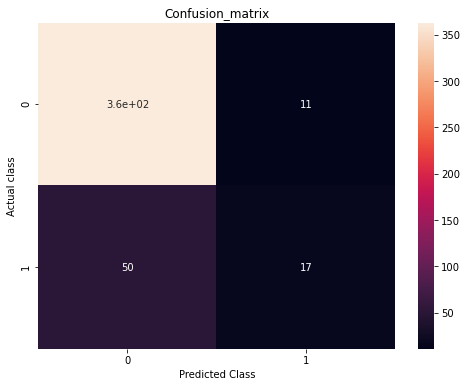

Confusion matrix: 
 [[363  11]
 [ 50  17]]
TP:  17
TN:  363
FP:  11
FN:  50


In [14]:
# Building random forest using the tuned parameter
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_features='auto', random_state=1)
rfc.fit(X_train,Y_train)
featimp = pd.Series(rfc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = rfc.predict(X_test)
print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# AdaBoost

WorkLifeBalance                      0.100000
TrainingTimesLastYear                0.085714
Education                            0.071429
StockOptionLevel                     0.057143
JobInvolvement                       0.057143
YearsAtCompany                       0.057143
MonthlyIncome                        0.057143
OverTime                             0.042857
EnvironmentSatisfaction              0.042857
YearsWithCurrManager                 0.028571
YearsSinceLastPromotion              0.028571
Age                                  0.028571
NumCompaniesWorked                   0.028571
JobSatisfaction                      0.028571
JobLevel                             0.028571
DistanceFromHome                     0.028571
PercentSalaryHike                    0.014286
TotalWorkingYears                    0.014286
BusinessTravel_Travel_Frequently     0.014286
YearsInCurrentRole                   0.014286
BusinessTravel_Non-Travel            0.014286
MaritalStatus_Single              

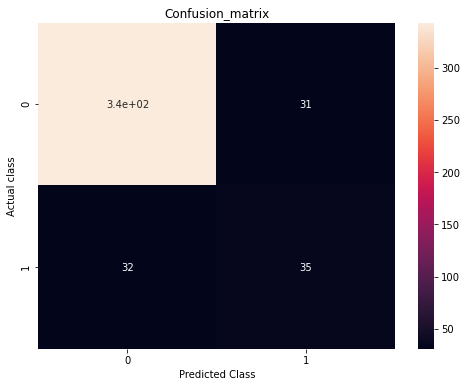

Confusion matrix: 
 [[343  31]
 [ 32  35]]
TP:  35
TN:  343
FP:  31
FN:  32


In [16]:
abc = AdaBoostClassifier(n_estimators=70, random_state=1)

abc.fit(X_train,Y_train)

featimp = pd.Series(abc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = abc.predict(X_test)

print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Gradient Boosting

OverTime                             0.289288
Age                                  0.070366
JobLevel                             0.061367
StockOptionLevel                     0.059401
WorkLifeBalance                      0.048623
MonthlyIncome                        0.044952
EnvironmentSatisfaction              0.042312
JobRole_Sales Executive              0.042078
YearsWithCurrManager                 0.038128
NumCompaniesWorked                   0.035665
JobSatisfaction                      0.030685
JobInvolvement                       0.030532
TrainingTimesLastYear                0.018383
MaritalStatus_Single                 0.018287
JobRole_Research Scientist           0.016991
YearsAtCompany                       0.016122
EducationField_Technical Degree      0.015384
BusinessTravel_Travel_Frequently     0.015223
DistanceFromHome                     0.014404
Education                            0.010070
YearsSinceLastPromotion              0.009050
JobRole_Manufacturing Director    

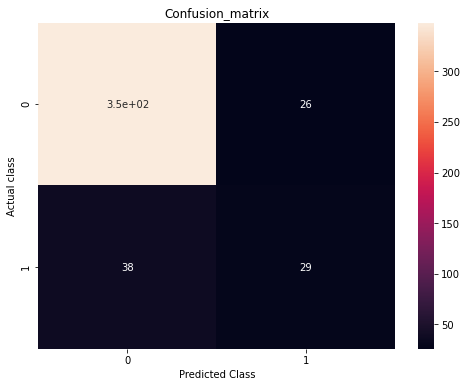

Confusion matrix: 
 [[348  26]
 [ 38  29]]
TP:  29
TN:  348
FP:  26
FN:  38


In [18]:
gbc = GradientBoostingClassifier(n_estimators= 10, learning_rate=0.5, max_depth=6, max_leaf_nodes=32, random_state=1)

gbc.fit(X_train,Y_train)

featimp = pd.Series(gbc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = gbc.predict(X_test)

print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# XGBoost

OverTime                             0.222686
JobLevel                             0.100581
JobRole_Sales Executive              0.076165
StockOptionLevel                     0.049745
MaritalStatus_Single                 0.039291
JobRole_Research Scientist           0.038858
EducationField_Technical Degree      0.026132
JobSatisfaction                      0.025791
EducationField_Other                 0.022599
BusinessTravel_Travel_Frequently     0.020597
BusinessTravel_Travel_Rarely         0.020098
NumCompaniesWorked                   0.020057
WorkLifeBalance                      0.018658
Age                                  0.018425
JobRole_Sales Representative         0.018360
YearsWithCurrManager                 0.017111
YearsSinceLastPromotion              0.017070
YearsAtCompany                       0.016328
Education                            0.015272
MaritalStatus_Divorced               0.014590
MaritalStatus_Married                0.014412
TrainingTimesLastYear             

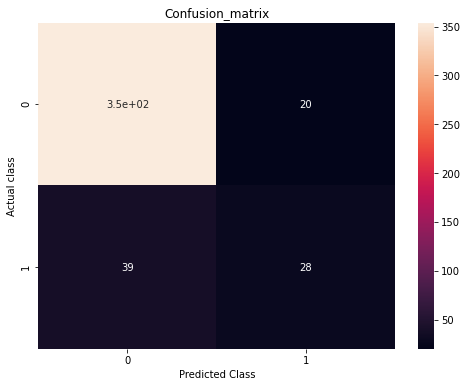

Confusion matrix: 
 [[354  20]
 [ 39  28]]
TP:  28
TN:  354
FP:  20
FN:  39


In [19]:
xgb = XGBClassifier(learning_rate=0.5, n_estimators=30, max_depth=9, min_child_weight=1, gamma=0.2, objective= 'binary:logistic', nthread=4, seed=1)

xgb.fit(X_train,Y_train)

featimp = pd.Series(xgb.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = xgb.predict(X_test)

print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Since the AdaBoost classifier had the least number of False Negatives, this model will be saved and deployed

# Fitting the best performing model with a reduced number of features - the aim here is to save and deploy a parsimonious model

Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.80      0.84       374
           1       0.27      0.42      0.33        67

    accuracy                           0.74       441
   macro avg       0.58      0.61      0.58       441
weighted avg       0.79      0.74      0.76       441



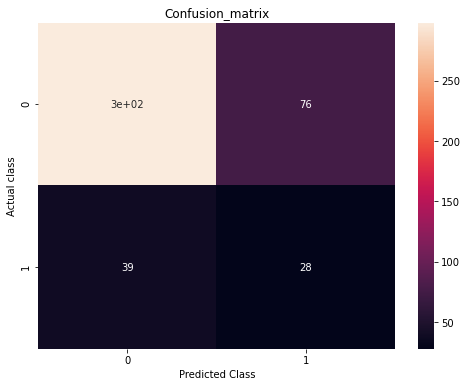

Confusion matrix: 
 [[298  76]
 [ 39  28]]
TP:  28
TN:  298
FP:  76
FN:  39


In [21]:
#4 features

X1 = final_data[['WorkLifeBalance', 'TrainingTimesLastYear', 'Education', 'StockOptionLevel']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)


abc = AdaBoostClassifier(n_estimators=70, random_state=1)

abc.fit(X1_train,Y1_train)

Y_pred = abc.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.78      0.83       374
           1       0.28      0.48      0.35        67

    accuracy                           0.73       441
   macro avg       0.59      0.63      0.59       441
weighted avg       0.80      0.73      0.76       441



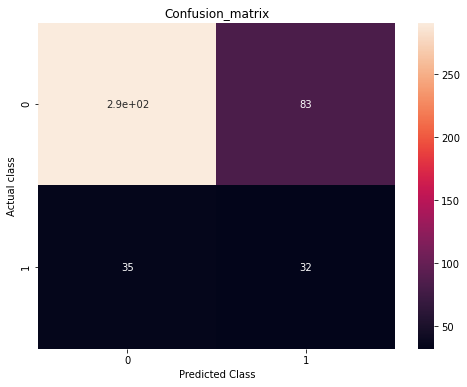

Confusion matrix: 
 [[291  83]
 [ 35  32]]
TP:  32
TN:  291
FP:  83
FN:  35


In [22]:
#5 features

X1 = final_data[['WorkLifeBalance', 'TrainingTimesLastYear', 'Education', 'StockOptionLevel', 'JobInvolvement']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

abc = AdaBoostClassifier(n_estimators=70, random_state=1)

abc.fit(X1_train,Y1_train)

Y_pred = abc.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.83      0.86       374
           1       0.32      0.45      0.37        67

    accuracy                           0.77       441
   macro avg       0.60      0.64      0.61       441
weighted avg       0.81      0.77      0.78       441



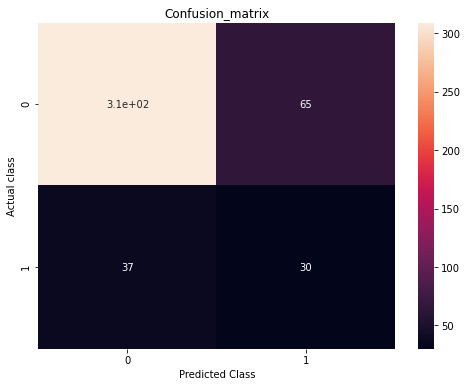

Confusion matrix: 
 [[309  65]
 [ 37  30]]
TP:  30
TN:  309
FP:  65
FN:  37


In [23]:
#6 features

X1 = final_data[['WorkLifeBalance', 'TrainingTimesLastYear', 'Education', 'StockOptionLevel', 'JobInvolvement', 'YearsAtCompany']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

abc = AdaBoostClassifier(n_estimators=70, random_state=1)

abc.fit(X1_train,Y1_train)

Y_pred = abc.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.82      0.85       374
           1       0.31      0.45      0.36        67

    accuracy                           0.76       441
   macro avg       0.60      0.63      0.61       441
weighted avg       0.80      0.76      0.78       441



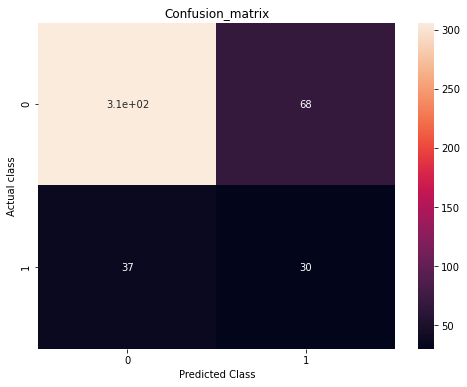

Confusion matrix: 
 [[306  68]
 [ 37  30]]
TP:  30
TN:  306
FP:  68
FN:  37


In [24]:
#7 features

X1 = final_data[['WorkLifeBalance', 'TrainingTimesLastYear', 'Education', 'StockOptionLevel', 'JobInvolvement', 'YearsAtCompany','MonthlyIncome']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

abc = AdaBoostClassifier(n_estimators=70, random_state=1)

abc.fit(X1_train,Y1_train)

Y_pred = abc.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.83      0.87       374
           1       0.37      0.55      0.44        67

    accuracy                           0.79       441
   macro avg       0.64      0.69      0.66       441
weighted avg       0.83      0.79      0.81       441



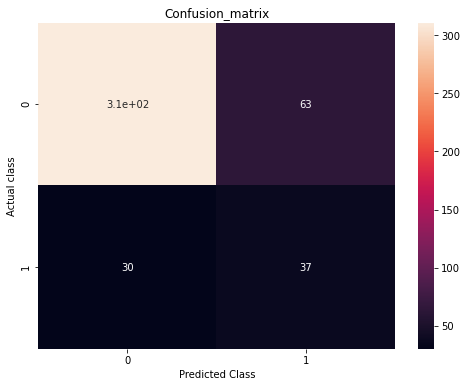

Confusion matrix: 
 [[311  63]
 [ 30  37]]
TP:  37
TN:  311
FP:  63
FN:  30


In [25]:
#8 features

X1 = final_data[['WorkLifeBalance', 'TrainingTimesLastYear', 'Education','StockOptionLevel', 'JobInvolvement', 'YearsAtCompany','MonthlyIncome','OverTime']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

abc = AdaBoostClassifier(n_estimators=70, random_state=1)

abc.fit(X1_train,Y1_train)

Y_pred = abc.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.87      0.90       374
           1       0.47      0.63      0.54        67

    accuracy                           0.83       441
   macro avg       0.70      0.75      0.72       441
weighted avg       0.86      0.83      0.84       441



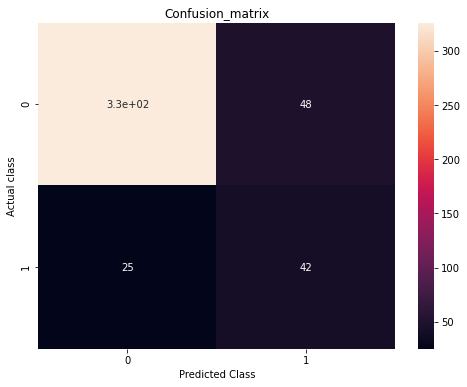

Confusion matrix: 
 [[326  48]
 [ 25  42]]
TP:  42
TN:  326
FP:  48
FN:  25


In [26]:
#9 features

X1 = final_data[['WorkLifeBalance', 'TrainingTimesLastYear', 'Education','StockOptionLevel', 'JobInvolvement', 'YearsAtCompany','MonthlyIncome','OverTime', 'EnvironmentSatisfaction']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

abc = AdaBoostClassifier(n_estimators=70, random_state=1)

abc.fit(X1_train,Y1_train)

Y_pred = abc.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.87      0.89       374
           1       0.44      0.60      0.51        67

    accuracy                           0.83       441
   macro avg       0.68      0.73      0.70       441
weighted avg       0.85      0.83      0.84       441



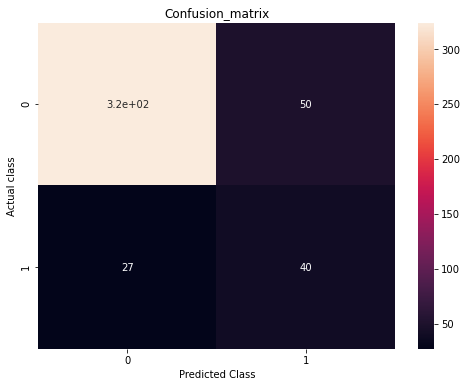

Confusion matrix: 
 [[324  50]
 [ 27  40]]
TP:  40
TN:  324
FP:  50
FN:  27


In [27]:
#10 features

X1 = final_data[['WorkLifeBalance', 'TrainingTimesLastYear', 'Education','StockOptionLevel', 'JobInvolvement', 'YearsAtCompany','MonthlyIncome','OverTime', 'EnvironmentSatisfaction', 'YearsWithCurrManager']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

abc = AdaBoostClassifier(n_estimators=70, random_state=1)

abc.fit(X1_train,Y1_train)

Y_pred = abc.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       374
           1       0.45      0.51      0.48        67

    accuracy                           0.83       441
   macro avg       0.68      0.70      0.69       441
weighted avg       0.84      0.83      0.83       441



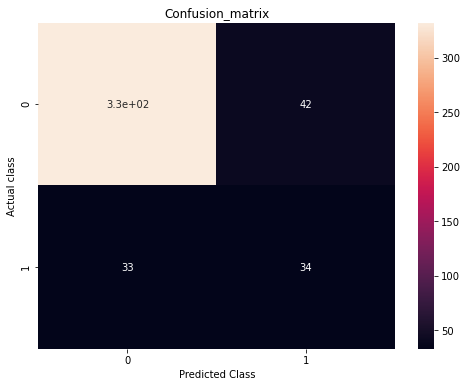

Confusion matrix: 
 [[332  42]
 [ 33  34]]
TP:  34
TN:  332
FP:  42
FN:  33


In [28]:
#11 features

X1 = final_data[['WorkLifeBalance', 'TrainingTimesLastYear', 'Education','StockOptionLevel', 'JobInvolvement', 'YearsAtCompany','MonthlyIncome','OverTime', 'EnvironmentSatisfaction', 'YearsWithCurrManager', 'YearsSinceLastPromotion']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

abc = AdaBoostClassifier(n_estimators=70, random_state=1)

abc.fit(X1_train,Y1_train)

Y_pred = abc.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       374
           1       0.49      0.51      0.50        67

    accuracy                           0.84       441
   macro avg       0.70      0.71      0.70       441
weighted avg       0.85      0.84      0.84       441



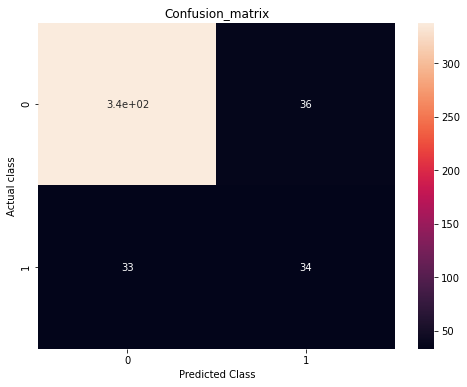

Confusion matrix: 
 [[338  36]
 [ 33  34]]
TP:  34
TN:  338
FP:  36
FN:  33


In [29]:
#12 features

X1 = final_data[['WorkLifeBalance', 'TrainingTimesLastYear', 'Education','StockOptionLevel', 'JobInvolvement', 'YearsAtCompany','MonthlyIncome','OverTime', 'EnvironmentSatisfaction', 'YearsWithCurrManager', 'YearsSinceLastPromotion', 'Age']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

abc = AdaBoostClassifier(n_estimators=70, random_state=1)

abc.fit(X1_train,Y1_train)

Y_pred = abc.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       374
           1       0.48      0.52      0.50        67

    accuracy                           0.84       441
   macro avg       0.70      0.71      0.70       441
weighted avg       0.85      0.84      0.84       441



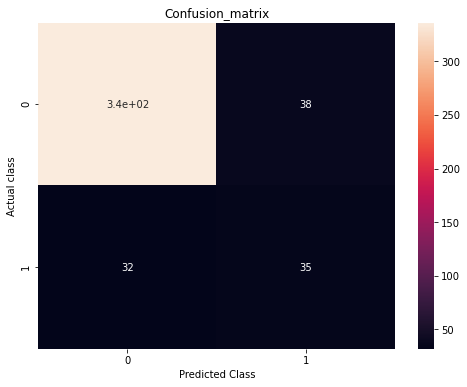

Confusion matrix: 
 [[336  38]
 [ 32  35]]
TP:  35
TN:  336
FP:  38
FN:  32


In [30]:
#13 features

X1 = final_data[['WorkLifeBalance', 'TrainingTimesLastYear', 'Education','StockOptionLevel', 'JobInvolvement', 'YearsAtCompany','MonthlyIncome','OverTime', 'EnvironmentSatisfaction', 'YearsWithCurrManager', 'YearsSinceLastPromotion', 'NumCompaniesWorked', 'Age']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

abc = AdaBoostClassifier(n_estimators=70, random_state=1)

abc.fit(X1_train,Y1_train)

Y_pred = abc.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.91      0.91       374
           1       0.51      0.55      0.53        67

    accuracy                           0.85       441
   macro avg       0.72      0.73      0.72       441
weighted avg       0.86      0.85      0.85       441



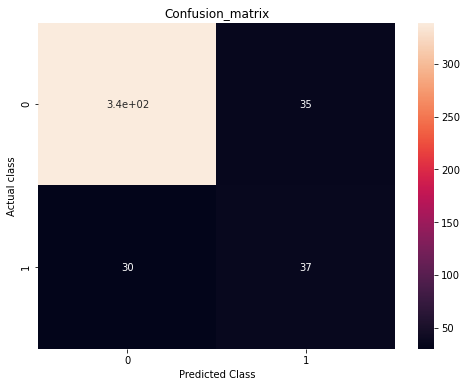

Confusion matrix: 
 [[339  35]
 [ 30  37]]
TP:  37
TN:  339
FP:  35
FN:  30


In [10]:
#14 features

X1 = final_data[['WorkLifeBalance', 'TrainingTimesLastYear', 'Education','StockOptionLevel', 'JobInvolvement', 'YearsAtCompany','MonthlyIncome','OverTime', 'EnvironmentSatisfaction', 'YearsWithCurrManager', 'YearsSinceLastPromotion', 'NumCompaniesWorked', 'Age', 'JobSatisfaction']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

abc_reduced_features = AdaBoostClassifier(n_estimators=70, random_state=1)

abc_reduced_features.fit(X1_train,Y1_train)

Y_pred = abc_reduced_features.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       374
           1       0.41      0.42      0.41        67

    accuracy                           0.82       441
   macro avg       0.65      0.65      0.65       441
weighted avg       0.82      0.82      0.82       441



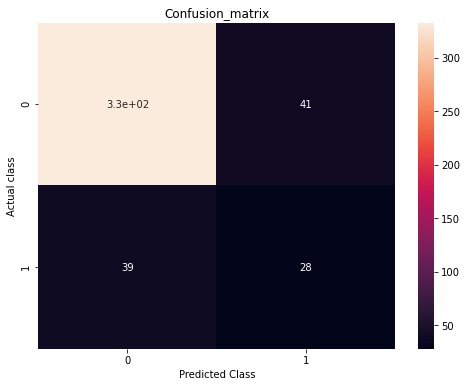

Confusion matrix: 
 [[333  41]
 [ 39  28]]
TP:  28
TN:  333
FP:  41
FN:  39


In [32]:
#15 features

X1 = final_data[['WorkLifeBalance', 'TrainingTimesLastYear', 'Education','StockOptionLevel', 'JobInvolvement', 'YearsAtCompany','MonthlyIncome','OverTime', 'EnvironmentSatisfaction', 'YearsWithCurrManager', 'YearsSinceLastPromotion', 'NumCompaniesWorked', 'Age', 'JobSatisfaction', 'JobLevel']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

abc = AdaBoostClassifier(n_estimators=70, random_state=1)

abc.fit(X1_train,Y1_train)

Y_pred = abc.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# The code below saves the AdaBoost model with 14 features to a pickle file. This is required to deploy the model

In [11]:
import pickle
# open a file, where you want to store the data
#The wb option stands for write binary

file = open('ada_boost_classification_model.pkl', 'wb')

# dump information to that file
pickle.dump(abc_reduced_features, file)